# Awareness Modeling


In [33]:
%matplotlib inline
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler
from pygsp import graphs, filters, plotting
from sklearn.decomposition import NMF, LatentDirichletAllocation
import json
import tqdm as tqdm

## Import the features from different pickles : 

In [70]:
# Helper function to standardize values in a list
def stand(mylist):  
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    return std_scaler.transform(np.array(mylist).reshape(-1, 1)) 

# Helper function to standardize values in a dataframe
def stand_df(df):
    maxvalue = df.replace(np.inf,0.0).max().max()
    infvalreplace = 2 * maxvalue
    df.replace(np.inf,infvalreplace,inplace=True)
    df.replace(np.nan,infvalreplace,inplace=True)
    myindex = df.index
    mycolumns = df.columns
    mylist = df.as_matrix()
    myshape = np.shape(mylist)
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    scaled_list = std_scaler.transform(np.array(mylist).reshape(-1, 1)).reshape(myshape)   
    return pd.DataFrame(scaled_list,index=myindex,columns=mycolumns)

In [95]:
# Loading the dataframe containing general information about countries
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
countries = c_data.index.tolist()
c_data = c_data.reset_index()
c_data = c_data.set_index("ISO2")

# Keep only relevant fields 
c_data = c_data[['ISO2','POP', 'area', 'gdp', 'gdp_capita', 'pop_pov']]
# Removing multi indexing 
c_data.columns = c_data.columns.droplevel(level = 1)


# Load all the distance metrics created between the different countries
lang_feature_df = pd.read_pickle('../LinkingLanguages/country_dist_languages.pkl')
lang_feature_df = stand_df(lang_feature_df)
lang_feature_df -= lang_feature_df.min().min()

fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes_std.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance_std.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance_std.pickle')
religion_and_more_df = pd.read_pickle('../GeoMetrics/rel_distance_df.pickle')
religion_and_more_df = stand_df(religion_and_more_df)
religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()

# Shift the standardized values by the minimum for the NMF :
lang_feature_df = lang_feature_df - lang_feature_df.min().min()
fligh_routes_df = fligh_routes_df - fligh_routes_df.min().min()
hop_distance_df = hop_distance_df - hop_distance_df.min().min()
neighbor_influence_df = neighbor_influence_df - neighbor_influence_df.min().min()
dist_feature_df = dist_feature_df - dist_feature_df.min().min()
#religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()


# Concatenate the dataframes with multi indexing
features_df = pd.concat([fligh_routes_df,
                         hop_distance_df,
                         neighbor_influence_df,
                         dist_feature_df],axis=1)

features_df.sort_index(axis=1,inplace=True)

# Removing multi indexing 
features_df.columns = features_df.columns.droplevel(level = 0)

# Concatenating remaining dataframes
features_df = pd.concat([features_df, lang_feature_df, religion_and_more_df,c_data], axis=1)

# Removing rows with NaNs 
features_df.dropna(thresh=0.9*features_df.shape[1], inplace = True)

print(len(features_df))
features_df.head(10)


247


,AD,AE,AF,AG,AI,AL,AM,AO,AQ,AR,...,WS,YE,ZA,ZM,ZW,POP,area,gdp,gdp_capita,pop_pov
AD,inf,inf,inf,0.119521,0.243244,inf,inf,inf,inf,inf,...,0.915975,1.716053,0.454804,2.616480,2.609464,85660.0,468.0,4.800000e+09,37200.0,0.143
AE,inf,inf,0.0966982,inf,inf,inf,0.0246263,0.0246263,inf,inf,...,1.230872,1.255804,0.972257,2.741310,2.734322,5927482.0,83600.0,3.750000e+11,67700.0,0.195
AF,inf,2.5044,inf,inf,inf,inf,inf,inf,inf,inf,...,2.873806,1.218927,2.753572,1.542684,1.530756,33332025.0,652230.0,1.840000e+10,2000.0,0.358
AG,0.292734,inf,inf,inf,0.292734,inf,inf,inf,inf,inf,...,0.146233,1.909949,0.387058,2.443685,2.439571,93581.0,442.0,1.303000e+09,24100.0,NaN
AI,4.15291,inf,inf,2.07435,inf,inf,inf,inf,inf,inf,...,0.153756,1.935923,0.446509,2.443410,2.438111,16752.0,91.0,1.754000e+08,12200.0,0.230
AL,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,1.131696,1.332125,0.812311,2.699132,2.698836,3038594.0,28748.0,1.214000e+10,11900.0,0.143
AM,inf,0.447657,inf,inf,inf,inf,inf,inf,inf,inf,...,2.462592,2.060699,2.536426,0.332234,0.238809,3051250.0,29743.0,1.075000e+10,8900.0,0.320
AO,inf,0.71254,inf,inf,inf,inf,inf,inf,inf,inf,...,2.487915,1.847019,2.472921,0.520096,0.609225,20172332.0,1246700.0,9.194000e+10,6800.0,0.405
AQ,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,1.524710,1.207935,1.300991,1.545567,1.533660,NaN,14000000.0,NaN,NaN,NaN
AR,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,2.732608,2.050256,2.681908,1.250916,1.360277,43886748.0,2780400.0,5.417000e+11,20200.0,0.300


In [96]:
#print([x for x in features_df.columns])


In [97]:
# convert every Nan to a 0 
        
to_standadize = ['POP','area','gdp', 'gdp_capita','pop_pov']
for i in to_standadize:
    
    features_df.loc[:,i] = stand(list(features_df.loc[:,i])).reshape((-1))
    features_df.loc[:,i] -=  features_df.loc[:,i].min()

features_df.head(20)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [81]:
features_df

,AD,AE,AF,AG,AI,AL,AM,AO,AQ,AR,...,WS,YE,ZA,ZM,ZW,POP,area,gdp,gdp_capita,pop_pov
AD,inf,inf,inf,0.119521,0.243244,inf,inf,inf,inf,inf,...,0.915975,1.716053,0.454804,2.616480,2.609464,8.566000e+04,468.00,4.800000e+09,3.720000e+04,0.143000
AE,inf,inf,0.096698,inf,inf,inf,0.024626,0.024626,inf,inf,...,1.230872,1.255804,0.972257,2.741310,2.734322,5.927482e+06,83600.00,3.750000e+11,6.770000e+04,0.195000
AF,inf,2.504397,inf,inf,inf,inf,inf,inf,inf,inf,...,2.873806,1.218927,2.753572,1.542684,1.530756,3.333202e+07,652230.00,1.840000e+10,2.000000e+03,0.358000
AG,0.292734,inf,inf,inf,0.292734,inf,inf,inf,inf,inf,...,0.146233,1.909949,0.387058,2.443685,2.439571,9.358100e+04,442.00,1.303000e+09,2.410000e+04,inf
AI,4.152905,inf,inf,2.074351,inf,inf,inf,inf,inf,inf,...,0.153756,1.935923,0.446509,2.443410,2.438111,1.675200e+04,91.00,1.754000e+08,1.220000e+04,0.230000
AL,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,1.131696,1.332125,0.812311,2.699132,2.698836,3.038594e+06,28748.00,1.214000e+10,1.190000e+04,0.143000
AM,inf,0.447657,inf,inf,inf,inf,inf,inf,inf,inf,...,2.462592,2.060699,2.536426,0.332234,0.238809,3.051250e+06,29743.00,1.075000e+10,8.900000e+03,0.320000
AO,inf,0.712540,inf,inf,inf,inf,inf,inf,inf,inf,...,2.487915,1.847019,2.472921,0.520096,0.609225,2.017233e+07,1246700.00,9.194000e+10,6.800000e+03,0.405000
AQ,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,1.524710,1.207935,1.300991,1.545567,1.533660,inf,14000000.00,inf,inf,inf
AR,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,2.732608,2.050256,2.681908,1.250916,1.360277,4.388675e+07,2780400.00,5.417000e+11,2.020000e+04,0.300000


## Applying the NMF

In [6]:
features_mat = features_df.as_matrix()


In [7]:
n_samples = np.shape(features_mat)[1]
n_features = len(features_df.columns)
n_components = round(np.shape(features_mat)[1]/3)

In [8]:
W = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit_transform(features_mat)

In [9]:
np.shape(W)

(248, 496)

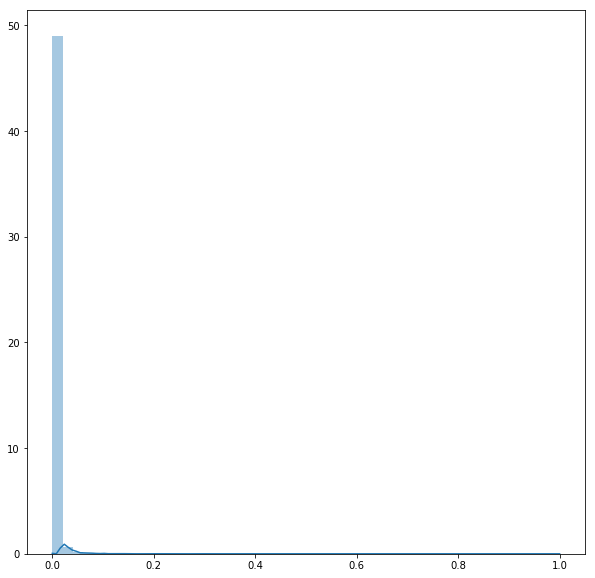

In [10]:
plt.figure(figsize=[10,10])
sns.distplot(W.flatten())

## Weight Matrix and Graph

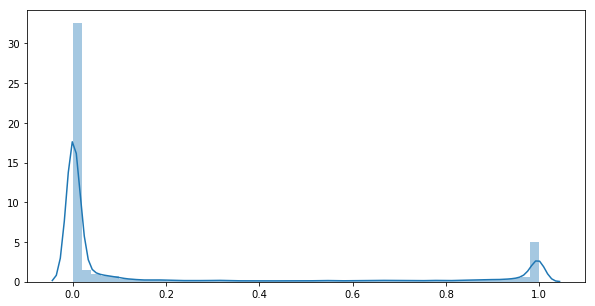

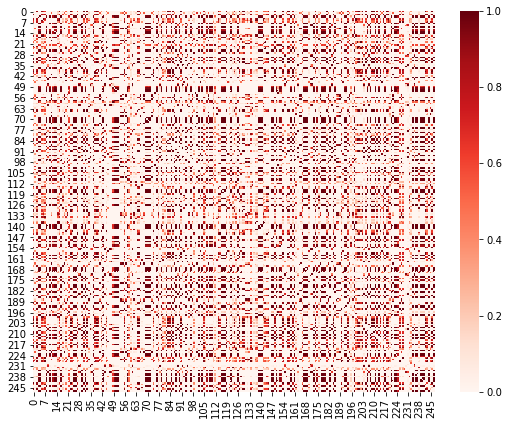

In [58]:
distances = spatial.distance.squareform(spatial.distance.pdist(W, 'cosine')) # W
#plt.figure(figsize=[9,7])
#sns.heatmap(distances)

kernel_width = np.mean(distances)- np.std(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :

plt.figure(figsize=[10,5])
sns.distplot(weights.flatten())
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [60]:
weights_df = pd.DataFrame(weights,columns=countries,index=countries)
country = 'Germany'
weights_df[country].loc[weights_df[country] >= 0.9].sort_values()

Mauritania                          0.930759
Cape Verde                          0.959392
Italy                               0.971046
Nauru                               0.975973
Anguilla                            0.977110
Puerto Rico                         0.982830
Israel                              0.984690
Burundi                             0.988628
Georgia                             0.990605
Antigua and Barbuda                 0.992379
Estonia                             0.993055
Senegal                             0.993159
Greenland                           0.995304
Montenegro                          0.995619
Trinidad and Tobago                 0.995872
Bolivia                             0.995958
Madagascar                          0.997218
Namibia                             0.997386
Gambia                              0.997613
Kosovo                              0.997851
Paraguay                            0.997980
Honduras                            0.998074
United Sta

In [15]:
weights_df.head()

,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
Aruba,0.000000e+00,2.534647e-34,2.335948e-01,7.584046e-04,9.857710e-04,2.251268e-01,7.597078e-02,5.778240e-02,1.022255e-03,8.765855e-13,...,1.760289e-06,9.620998e-04,9.974588e-04,9.764878e-04,4.969534e-01,3.442602e-02,9.971338e-04,9.132733e-06,3.389176e-01,9.753205e-04
Afghanistan,2.534647e-34,0.000000e+00,1.522437e-32,3.936823e-34,5.054514e-34,6.132989e-33,1.873776e-30,3.241776e-31,5.240801e-34,4.559919e-43,...,2.361334e-25,4.953838e-34,5.117288e-34,5.038631e-34,6.018185e-35,8.857248e-33,5.118184e-34,1.211886e-31,6.555160e-34,5.012380e-34
Angola,2.335948e-01,1.522437e-32,0.000000e+00,1.744746e-03,2.265920e-03,2.099053e-01,9.392667e-02,1.539295e-01,2.351345e-03,2.018856e-12,...,5.837217e-05,2.214977e-03,2.294953e-03,2.246728e-03,2.719740e-01,3.411329e-01,2.294851e-03,9.207682e-05,4.181434e-01,2.245031e-03
Anguilla,7.584046e-04,3.936823e-34,1.744746e-03,0.000000e+00,8.864103e-01,1.168032e-03,5.842745e-04,9.957711e-04,8.628057e-01,2.067336e-09,...,8.199196e-08,8.575171e-01,8.577579e-01,8.732035e-01,4.908727e-04,8.169035e-04,8.477717e-01,8.726204e-07,9.064431e-04,8.576699e-01
Åland Islands,9.857710e-04,5.054514e-34,2.265920e-03,8.864103e-01,0.000000e+00,1.512957e-03,7.564440e-04,1.289233e-03,9.940641e-01,1.153056e-09,...,1.062476e-07,9.834420e-01,9.914510e-01,9.903725e-01,6.396104e-04,1.060302e-03,9.902970e-01,1.126059e-06,1.179482e-03,9.858016e-01


In [38]:

# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)


weights_df = pd.DataFrame(weights,columns=countries,index=c_data.index.tolist())
weights_df.drop("United States Minor Outlying Islands",inplace = True)
weights_df.drop("United States Minor Outlying Islands", axis = 1,inplace = True)

country_pos = np.array(c_data[['latlng']].as_matrix())
country_pos = [ np.array(x[0]) for x in country_pos]
country_pos = np.vstack(country_pos)
country_pos = np.transpose(np.vstack((country_pos[:,1], country_pos[:,0])))

# Create the graph
G = graphs.Graph(weights_df.as_matrix())

G.set_coordinates(country_pos)
G.compute_fourier_basis()

# Create the heat diffusion filter
filt = filters.Heat(G, tau=100)


# Create the signal for a given country
for NODE, country in enumerate(weights_df.index):
    
    signal = np.zeros(G.N)
    signal[NODE] = 10

    # Apply the filter to the signal
    filtered_s = filt.filter(signal)
    
   
    if NODE > 0:
        filtered_signals = np.vstack((filtered_signals, filtered_s))
    else : 
        filtered_signals = filtered_s
        
    #print(np.shape(filtered_signals), np.shape(filtered_s))
    # Plot the signal on the graph
    #G.plot_signal(filtered_s, vertex_size=50, highlight=NODE)

filtered_signals = np.transpose(filtered_signals)


In [30]:
print(np.shape(filtered_signals))

(247, 247)


In [42]:
diffusion_json = {}

country_names = c_data.ISO3.tolist()

diffusion_df = pd.DataFrame(filtered_signals, columns = country_names, index = country_names)

graph_diffusion_json = diffusion_df.to_json(force_ascii=False,orient='columns')


diffusion_json['graph_diffusion'] = dict(json.loads(graph_diffusion_json))

story_path = '../../../Data-Story/'
metrics_file = open(os.path.join(story_path,'III-Analysis','diffusion.json'), 'w')

json.dump(diffusion_json,metrics_file,separators=(',', ':'), indent=4)
metrics_file.close()


In [43]:
diffusion_json

{'graph_diffusion': {'ABW': {'ABW': 0.1297893616,
   'AFG': 5.960114855e-24,
   'AGO': 0.127250325,
   'AIA': 0.0084353199,
   'ALA': 0.0084577447,
   'ALB': 0.1184344364,
   'AND': 0.1068645165,
   'ARE': 0.1244465943,
   'ARG': 0.0084608249,
   'ARM': 1.83667e-05,
   'ASM': 0.0084583108,
   'ATA': 4.474333657e-16,
   'ATF': 0.0084080582,
   'ATG': 0.0084459396,
   'AUS': 0.008460784,
   'AUT': 0.0623860188,
   'AZE': 0.1157797822,
   'BDI': 0.0084393545,
   'BEL': 0.0247973146,
   'BEN': 0.0,
   'BFA': 0.1261406241,
   'BGD': 0.0004059913,
   'BGR': 0.0083815781,
   'BHR': 0.1305466264,
   'BHS': 0.1280924453,
   'BIH': 0.0084606482,
   'BLM': 0.0084563229,
   'BLR': 0.1261019798,
   'BLZ': 0.001110058,
   'BMU': 8.483e-06,
   'BOL': 0.0084495841,
   'BRA': 0.1302974213,
   'BRB': 0.0084607221,
   'BRN': 0.1306042749,
   'BTN': 0.0010873573,
   'BVT': 0.0016362874,
   'BWA': 0.0,
   'CAF': 0.0084603698,
   'CAN': 0.1289985179,
   'CCK': 0.1303005217,
   'CHE': 0.1299208087,
   'CHL':